## Solve a life-cycle consumption/saving problem 

- This notebook reproduces the life cycle consumption model by Gourinchas and Parker 2002 

  - CRRA utility 
  - No bequest motive
  - During work: labor income risk: permanent + transitory/unemployment 
  - During retirement: no risk



In [62]:
import numpy as np
import pandas as pd
from quantecon.optimize import brent_max, brentq
from interpolation import interp, mlinterp
from scipy import interpolate
import numba as nb
from numba import njit, float64, int64, boolean,jitclass
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain
import quantecon as qe 
from mpl_toolkits.mplot3d import Axes3D

In [10]:
## figures configurations

mp.rc('xtick', labelsize=14) 
mp.rc('ytick', labelsize=14) 

fontsize = 14
legendsize = 12

## The Model Class and Solver

In [11]:
lc_data = [
    ('ρ', float64),              # utility parameter CRRA
    ('β', float64),              # discount factor
    ('R',float64),               # Nominal interest rate factor 
    ('P', float64[:, :]),        # transition probs for z_t        x
    ('z_val', float64[:]),       # values of z                     x
    #('a_s', float64),           # preference volatility        x 
    #('sigma_s', float64),        # loading of macro state to preference    x
    ('sigma_n', float64),         # permanent shock volatility              x
    ('b_y', float64),            # loading of macro state to income
    ('sigma_u', float64),        # transitory shock volatility
    ('U',float64),               # the probability of being unemployed    * 
    ('s_grid', float64[:]),      # Grid over savings
    ('n_shk_draws', float64[:]),   ## Draws of permanent income shock for MC
    ('u_shk_draws', float64[:]),   # Draws of transitory income shock for MC
    ('ue_shk_draws',boolean[:]),     # Draws of unemployment shock 
    #('ζ_draws', float64[:])      # Draws of preference shock ζ for MC
    ('T',int64),                 # years of work                          *   
    ('L',int64),                 # years of life                          * 
    ('G',float64)               # growth rate of permanent income    * 
]

In [12]:
@jitclass(lc_data)
class LifeCycle:
    """
    A class that stores primitives for the life cycle consumption
    problem.
    """

    def __init__(self,
                 ρ = 2,
                 β = 0.96,
                 P = np.array([(0.9, 0.1),
                             (0.1, 0.9)]),
                 z_val = np.array([1.0,2.0]), 
                 #a_s = 0.02,     ## size of the taste shock  
                 #b_s = 0.0,   ## coefficient of pandemic state on taste 
                 sigma_u = 0.2,     ## size of transitory income risks
                 U = 0.01,          ## unemployment risk 
                 b_y = 0.0,         ## loading of macro state on income 
                 sigma_n = 0.15,     ## size of permanent income shocks
                 R = 1.03,
                 T = 40,             ## work age, from 25 to 65
                 L = 60,             ## life length 85
                 G = 1.0,            ## growth rate of permanent income 
                 shock_draw_size = 50,
                 grid_max = 2.5,
                 grid_size = 100,
                 seed = 1234):

        np.random.seed(seed)  # arbitrary seed

        self.ρ, self.β = ρ, β
        
        self.R = R 
        self.sigma_u, self.b_y = sigma_u, b_y
        self.sigma_n = sigma_n
        
        self.n_shk_draws = sigma_n*np.random.randn(shock_draw_size)-sigma_n**2/2
        self.u_shk_draws = sigma_u*np.random.randn(shock_draw_size)-sigma_u**2/2
        self.ue_shk_draws = np.random.uniform(0,1,shock_draw_size)<U

        self.s_grid = np.exp(np.linspace(np.log(1e-6), np.log(grid_max), grid_size))
        # This creates an unevenly spaced grids where grids are more dense in low values
        
        self.P, self.z_val = P, z_val
        self.G = G
        self.T,self.L = T,L
        # Test stability assuming {R_t} is IID and adopts the lognormal
        # specification given below.  The test is then β E R_t < 1.
        #ER = np.exp(b_r + a_r**2 / 2)
        assert β * R < 1, "Stability condition failed."

    # Marginal utility
    def u_prime(self, c):
        return c**(-self.ρ)

    # Inverse of marginal utility
    def u_prime_inv(self, c):
        return c**(-1/self.ρ)

    #def ϕ(self, z, ζ):
    #    ## preference 
    #    return np.exp(self.sigma_s * ζ + (z*self.b_s))

    def Y(self, z, u_shk):
        ## income 
        return np.exp(u_shk + (z * self.b_y))
    
    def Γ(self,n_shk):
        return np.exp(n_shk)

In [13]:
@njit
def K(a_in, σ_in, lc):
    """
    The Coleman--Reffett operator for the life-cycle consumption problem,
    using the endogenous grid method.

        * lc is an instance of life cycle model
        * a_in[i, z] is an asset grid
        * σ_in[i, z] is consumption at a_in[i, z]
    """

    # Simplify names
    u_prime, u_prime_inv = lc.u_prime, lc.u_prime_inv
    R, ρ, P, β = lc.R, lc.ρ, lc.P, lc.β
    z_val = lc.z_val
    s_grid, n_shk_draws, u_shk_draws, ue_shk_draws= lc.s_grid, lc.n_shk_draws, lc.u_shk_draws, lc.ue_shk_draws
    Y = lc.Y
    ####################
    ρ = lc.ρ
    Γ = lc.Γ
    G = lc.G
    ###################
    
    n = len(P)

    # Create consumption function by linear interpolation
    σ = lambda a, z: interp(a_in[:, z], σ_in[:, z], a)

    # Allocate memory
    σ_out = np.empty_like(σ_in)

    # Obtain c_i at each s_i, z, store in σ_out[i, z], computing
    # the expectation term by Monte Carlo
    for i, s in enumerate(s_grid):
        for z in range(n):
            # Compute expectation
            Ez = 0.0
            for z_hat in range(n):
                z_val_hat = z_val[z_hat]
                for u_shk in lc.u_shk_draws:
                    for ue_shk in lc.ue_shk_draws:
                        for n_shk in lc.n_shk_draws:
                            Γ_hat = Γ(n_shk) 
                            Y_hat = Y(z_val_hat, u_shk)*(1-ue_shk) ## conditional employed 
                            utility = (G*Γ_hat)**(1-ρ)*u_prime(σ(R/(G*Γ_hat) * s + Y_hat, z_hat))
                            Ez += utility * P[z, z_hat]
            Ez = Ez / (len(n_shk_draws)*len(u_shk_draws)*len(ue_shk_draws))
            σ_out[i, z] =  u_prime_inv(β * R* Ez)

    # Calculate endogenous asset grid
    a_out = np.empty_like(σ_out)
    for z in range(n):
        a_out[:, z] = s_grid + σ_out[:, z]

    # Fixing a consumption-asset pair at (0, 0) improves interpolation
    σ_out[0, :] = 0.0
    a_out[0, :] = 0.0

    return a_out, σ_out

In [14]:
def solve_model_backward_iter(model,        # Class with model information
                              a_vec,        # Initial condition for assets
                              σ_vec,        # Initial condition for consumption
                              #tol=1e-6,
                              #max_iter=2000,
                              #verbose=True,
                              #print_skip=50
                             ):

    # Set up loop
    #i = 0
    #error = tol + 1

    ## memories for life-cycle solutions 
    n_grids = len(σ_vec)
    n_z = len(model.P)                       
    as_new =  np.empty((model.T,n_grids,n_z),dtype = np.float64)
    σs_new =  np.empty((model.T,n_grids,n_z),dtype = np.float64)
    
    as_new[0,:,:] = a_vec
    σs_new[0,:,:] = σ_vec
    
    for i in range(model.T-1):
        print(f"at work age of "+str(model.T-i))
        a_vec_next, σ_vec_next = as_new[i,:,:],σs_new[i,:,:]
        a_new, σ_new = K(a_vec_next, σ_vec_next, model)
        as_new[i+1,:,:] = a_new
        σs_new[i+1,:,:] = σ_new
    
    #while i < max_iter and error > tol:
    #    a_new, σ_new = K(a_vec, σ_vec, model)
    #    error = np.max(np.abs(σ_vec - σ_new))
    #    i += 1
    #    if verbose and i % print_skip == 0:
    #        print(f"Error at iteration {i} is {error}.")
    #    a_vec, σ_vec = np.copy(a_new), np.copy(σ_new)

    #if i == max_iter:
    #    print("Failed to converge!")

    #if verbose and i < max_iter:
    #    print(f"\nConverged in {i} iterations.")

    return as_new, σs_new

In [15]:
def policyfunc(lc,
               a_star,
               σ_star,
               discrete = True):
    """
     * ifp is an instance of IFP
        * a_star is the endogenous grid solution
        * σ_star is optimal consumption on the grid    
    """
    if discrete==True:
        # Create consumption function by linear interpolation
        σ =  lambda a, z_idx: interp(a_star[:, z_idx], σ_star[:, z_idx], a) 
    else:
        # get z_grid 
        z_val = lc.z_val 

        # Create consumption function by linear interpolation
        a = a_star[:,0]                                ## aseet grid 
        σ =  interpolate.interp2d(a, z_val, σ_star.T) 
    
    return σ

## Solve the model for some consumption from the last period 

In [16]:
## this is the retirement consumption policy 

def policyPF(β,
             ρ,
             R,
             T,
             L):
    c_growth = β**(1/ρ)*R**(1/ρ-1)
    return (1-c_growth)/(1-c_growth**(L-T))

In [20]:
## intialize 

lc = LifeCycle()

# Initial the retirement consumption policy of σ = consume all assets

#mpc_ret = policyPF(lc.β,
#                   lc.ρ,
#                   lc.R,
#                   lc.T,
#                   lc.L) 
#ratio = mpc_ret/(1-mpc_ret)

k = len(lc.s_grid)
n = len(lc.P)
σ_init = np.empty((k, n))
a_init = np.empty((k, n))

for z in range(n):
    σ_init[:, z] = 2*lc.s_grid
    a_init[:,z] =  2*lc.s_grid

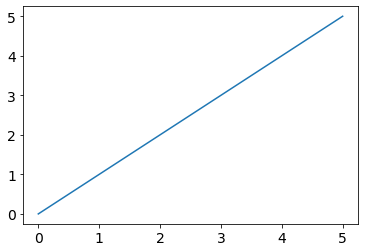

In [21]:
plt.title('The consumption in the last period')
plt.plot(σ_init[:,1],a_init[:,1])

In [22]:
#print('The MPC out of cash in hand at the retirement is '+ str(mpc_ret))

In [23]:
## Set quarterly parameters 

lc.ρ = 0.5
lc.R = 1.03
lc.β = 0.96

lc.sigma_n = np.sqrt(0.02) # permanent 
lc.sigma_u = np.sqrt(0.04) # transitory 

In [24]:
## shut down the macro state 

lc.b_y = 0.00

In [25]:
as_star, σs_star = solve_model_backward_iter(lc,
                                             a_init, 
                                             σ_init)

at work age of 40
at work age of 39
at work age of 38
at work age of 37
at work age of 36
at work age of 35
at work age of 34
at work age of 33
at work age of 32
at work age of 31
at work age of 30
at work age of 29
at work age of 28
at work age of 27
at work age of 26
at work age of 25
at work age of 24
at work age of 23
at work age of 22
at work age of 21
at work age of 20
at work age of 19
at work age of 18
at work age of 17
at work age of 16
at work age of 15
at work age of 14
at work age of 13
at work age of 12
at work age of 11
at work age of 10
at work age of 9
at work age of 8
at work age of 7
at work age of 6
at work age of 5
at work age of 4
at work age of 3
at work age of 2


### Plot interpolated policy functions

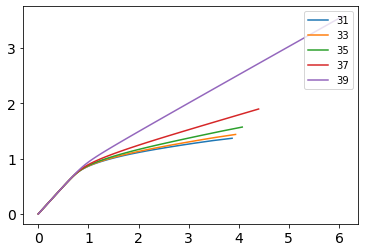

In [32]:
ages  = [31,33,35,37,39]

fig = plt.plot()
for age in ages:
    i = lc.T-age
    plt.plot(as_star[i,:,0],
             σs_star[i,:,0],
             label = str(age))
#plt.plot(as_star[0,:,0],as_star[0,:,0],'-')
plt.legend(loc=1)

In [43]:
## interpolate consumption function on continuous z grid 

σs_list = []

for i in range(lc.T):
    this_σ= policyfunc(lc,
                   as_star[i,:,:],
                   σs_star[i,:,:],
                   discrete = False)
    σs_list.append(this_σ)

Text(0, 0.5, 'another state')

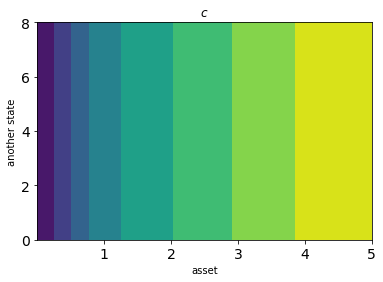

In [49]:
## plot contour for policy function 

a_grid = np.linspace(0.00001,5,20)
z_grid = np.linspace(0,8,20)
aa,zz = np.meshgrid(a_grid,z_grid)

σ_this = σs_list[3]

c_stars = σ_this(a_grid,z_grid)

cp = plt.contourf(aa, zz,c_stars)
plt.title(r'$c$')
plt.xlabel('asset')
plt.ylabel('another state')

In [ ]:
## plot 3d consumption function 


x,y,z =σs_star

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'red')
plt.savefig("demo.png")

In [ ]:
## plot 3d functions 
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dem3d=ax.plot_surface(xv,yv,dem_100,cmap='afmhot', linewidth=0)
ax.set_title('consumption function over life cycle')
ax.set_zlabel('wealth')
plt.show()

### Adding a macro Markov/persistent state 

In [52]:
## initialize another 
lc_ag = LifeCycle()

In [53]:
## tauchenize an ar1

ρ, σ = (0.98,0.18)
constant = 0.13  

mc = qe.markov.approximation.tauchen(ρ, σ, b=constant, m=3, n=7)
z_ss_av = constant/(1-ρ)
z_ss_sd = σ*np.sqrt(1/(1-ρ**2))

## feed the model with a markov matrix of macro state 
lc_ag.z_val, lc_ag.P = mc.state_values, mc.P

## set the macro state loading to be positive
lc_ag.b_y = 0.1

In [54]:
## initialize policies 

k = len(lc_ag.s_grid)
n = len(lc_ag.P)
σ_init = np.empty((k, n))
a_init = np.empty((k, n))

for z in range(n):
    σ_init[:, z] = 2*lc_ag.s_grid
    a_init[:,z] =  2*lc_ag.s_grid

In [55]:
as_star_ag, σs_star_ag = solve_model_backward_iter(lc_ag,
                                                   a_init,
                                                   σ_init)

at work age of 40
at work age of 39
at work age of 38
at work age of 37
at work age of 36
at work age of 35
at work age of 34
at work age of 33
at work age of 32
at work age of 31
at work age of 30
at work age of 29
at work age of 28
at work age of 27
at work age of 26
at work age of 25
at work age of 24
at work age of 23
at work age of 22
at work age of 21
at work age of 20
at work age of 19
at work age of 18
at work age of 17
at work age of 16
at work age of 15
at work age of 14
at work age of 13
at work age of 12
at work age of 11
at work age of 10
at work age of 9
at work age of 8
at work age of 7
at work age of 6
at work age of 5
at work age of 4
at work age of 3
at work age of 2


In [58]:
## interpolate consumption function on continuous z grid 

σs_ag_list = []

for i in range(lc_ag.T):
    this_σ= policyfunc(lc_ag,
                   as_star_ag[i,:,:],
                   σs_star_ag[i,:,:],
                   discrete = False)
    σs_ag_list.append(this_σ)

Text(0, 0.5, 'macro state')

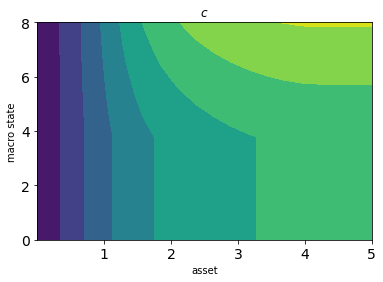

In [61]:
## plot contour for policy function 

a_grid = np.linspace(0.00001,5,20)
z_grid = np.linspace(0,8,20)
aa,zz = np.meshgrid(a_grid,z_grid)

σ_this = σs_ag_list[15]

c_stars = σ_this(a_grid,z_grid)

cp = plt.contourf(aa, zz,c_stars)
plt.title(r'$c$')
plt.xlabel('asset')
plt.ylabel('macro state')

## Simulate a cross history 

In [73]:
#@njit
def simulate_time_series(lc, σ, z_idx_seq, p_income,T=400):
    """
    Simulates a time series of length T for assets/consumptions, given optimal
    consumption/demand functions.
    * z_seq is a time path for {Z_t} recorded by index, instead of its numeric value

    """
    
    # Simulate the asset path
    a = np.zeros(T)+1e-4
    c  = np.empty_like(a)
    #c1 = np.empty_like(a)
    #c2 = np.empty_like(a)
    
    ## simulate histories
    ζ_sim = np.random.randn(T)
    η_sim = np.random.randn(T)
    
    
    R = lc.R
    z_val = lc.z_val ## values of the state 
    
    
    ## permanent income shocks
    
    Γs = p_income[1:]/p_income[:-1] 
    
    for t in range(T):
        z_idx = z_idx_seq[t]
        z = z_val[z_idx]    
        S = lc.ϕ(z,ζ_sim[t])
        Y = lc.Y(z, η_sim[t])
        c[t] = σ(a[t], z_idx)
        #c1[t],c2[t] = allocate(c[t], S = S) 
        #if t<T-1:
        #    a[t+1] = R/Γs[t] * (a[t] - c1[t]*p_vec[0]-c2[t]*p_vec[1]) + Y
        if t<T-1:
            a[t+1] = R/Γs[t] * (a[t] - c[t]) + Y
        
    ## multiply permanent income level 
    #c = c*p_income
    #c1 =c1*p_income
    #c2 = c2*p_income
    #a = a * p_income 
    
    return a,c

def simulate_time_series_new(lc, σ, z_seq, p_income, T=400):
    """
    Simulates a time series of length T for assets/consumptions, given optimal
    consumption/demand functions.

        * ifp is an instance of IFP
        * a_star is the endogenous grid solution
        * σ_star is optimal consumption on the grid
        * z_seq is a time path for {Z_t} recorded by its numeric value (different from the previous function)

    """
    
    # Simulate the asset path
    a = np.zeros(T)+1e-4
    c = np.empty_like(a)
    #c1 = np.empty_like(a)
    #c2 = np.empty_like(a)
    
    ## simulate histories
    ζ_sim = np.random.randn(T)
    η_sim = np.random.randn(T)
    
    
    R = lc.R
    #z_val = ifp.z_val ## values of the state 
    
    ## permanent income shocks
    
    Γs = p_income[1:]/p_income[:-1] 
    
    for t in range(T):
        z = z_seq[t] ## z values
        S = lc.ϕ(z,ζ_sim[t])
        Y = lc.Y(z, η_sim[t])
        c[t] = σ(a[t], z)
        #c1[t],c2[t] = allocate(c[t], S = S) 
        #if t<T-1:
        #    a[t+1] = R/Γs[t] * (a[t] - c1[t]*p_vec[0]-c2[t]*p_vec[1]) + Y
        if t<T-1:
            a[t+1] = R/Γs[t] * (a[t] - c[t]) + Y
        
    ## multiply permanent income level 
    #c = c*p_income
    #c1 =c1*p_income
    #c2 = c2*p_income
    #a = a * p_income 
    
    return a,c

## now, we simulate the time-series of a cross-sectional matrix of N agents 

#@njit
def simulate_distribution(lc, 
                          a_star, 
                          p_vec, 
                          σ_star,
                          z_mat, 
                          p_income_mat,
                          N = 3000, 
                          T = 400,
                          discrete = True):
    N_z, T_z = z_mat.shape
    
    assert N_z>=N and T_z >=T, 'history of the markov states are smaller than the simulated matrix'
    
    
    z_mat = z_mat[0:N,0:T]
    ## z_mat is a N_sim x T sized matrix that takes the simulated Markov states 
    a_mat = np.empty((N,T))
    c_mat = np.empty((N,T))
    #c1_mat = np.empty((N,T))
    #c2_mat = np.empty((N,T))
    
    ## get the policy function
    
    if discrete ==True:
        σ = policyfunc(lc,
                       a_star,
                       σ_star,
                       discrete = True)  ## interpolate for discrete z index 
        for i in range (N):
            a_mat[i,:],c_mat[i,:] = simulate_time_series(lc,
                                                         σ,
                                                         z_mat[i,:],
                                                         p_income_mat[i,:],
                                                         T = T)
    else:
        σ = policyfunc(lc,
                       a_star,
                       σ_star,
                       discrete = False) ## interpolate for continous z value 
        for i in range (N):
            a_mat[i,:],c_mat[i,:]= simulate_time_series_new(lc,
                                                            σ,
                                                            z_mat[i,:],
                                                            p_income_mat[i,:],
                                                            T = T)
            
    ## multiply permanent income level 
    #c_mat= np.multiply(c_mat,p_income_mat)
    #c1_mat = np.multiply(c1_mat,p_income_mat)
    #c2_mat = np.multiply(c2_mat,p_income_mat)
    #a_mat = np.multiply(a_mat,p_income_mat) 

    return a_mat,c_mat

In [74]:
## simulate a Markov sequence 

mc = MarkovChain(lc.P)

### Simulate history of Idiosyncratic Z states 
#### (For Z to be aggregate state. We can directly copy Z for different agents) 

## number of agents 

N = 1000
T = 25        ## simulated history of time period

z_idx_ts = mc.simulate(T, random_state=13274)
z_idx_mat = np.tile(z_idx_ts,(N,1))

In [75]:
## simulate a permanent income distributions 

@njit
def PerIncSimulate(T,
               sigma,
               init = 0.001):
    pshk_draws = sigma*np.random.randn(T)-sigma**2/2
    log_p_inc = np.empty(T)
    log_p_inc[0] = init
    for t in range(T-1):
        log_p_inc[t+1] = log_p_inc[t]+ pshk_draws[t+1]
    p_income = np.exp(log_p_inc)
    return p_income

## simulate histories of permanent income 

p_income_mat = np.empty((N,T))

for n in range(N):
    p_income_mat[n,:] = PerIncSimulate(T,
                                       sigma = lc.sigma_n,
                                       init = 0.0001)

In [78]:
## Simulate the distribution of consumption/asset (perfect understanding)

p_vec = (1,1) 
a_dist,c_dist = simulate_distribution(lc,
                                      a_bf_star,
                                      p_vec,
                                      σ_bf_star,
                                      z_idx_mat,
                                      p_income_mat,
                                      N = N,
                                      T = T,
                                      discrete = True)

NameError: name 'a_bf_star' is not defined

In [51]:
## aggregate history 

co_mat = np.multiply(c_dist,p_income_mat)  ## non-normalized consumption
lco_mat = np.log(co_mat)
lco_av = np.mean(lco_mat,axis = 0)

#p_av =  np.mean(p_income_mat,axis = 0)  
#lp_av = np.log(p_av)
lp_income_mat = np.log(p_income_mat)   ## permanent income level 
lp_av = np.mean(lp_income_mat,axis = 0)

#c_av = np.mean(c_dist,axis=0)
#lc_av = np.log(c_av)
lc_mat = np.log(c_dist)             ## normalized consumption
lc_av = np.mean(lc_mat,axis = 0) 

lc_sd = np.sqrt(np.diag(np.cov(lc_mat.T)))

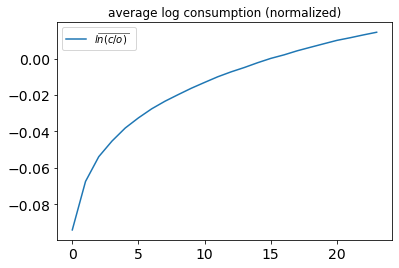

In [52]:
plt.title('average log consumption (normalized)')
plt.plot(lc_av[1:],label = r'$\widebar{ln(c/o)}$')
plt.legend(loc=2)

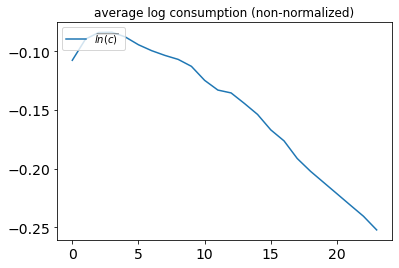

In [53]:
plt.title('average log consumption (non-normalized)')
plt.plot(lco_av[1:],label = r'$\widebar{ln(c)}$')
plt.legend(loc=2)

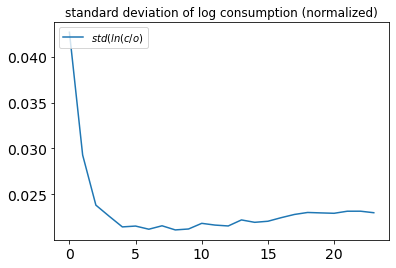

In [54]:
plt.title('standard deviation of log consumption (normalized)')
plt.plot(lc_sd[1:],label = r'$std(ln(c/o)$')
plt.legend(loc=2)

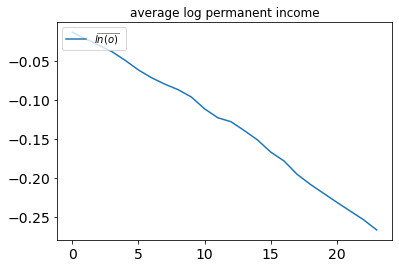

In [55]:
plt.title('average log permanent income')
plt.plot(lp_av[1:],label = r'$\widebar{ln(o)}$')
plt.legend(loc=2)

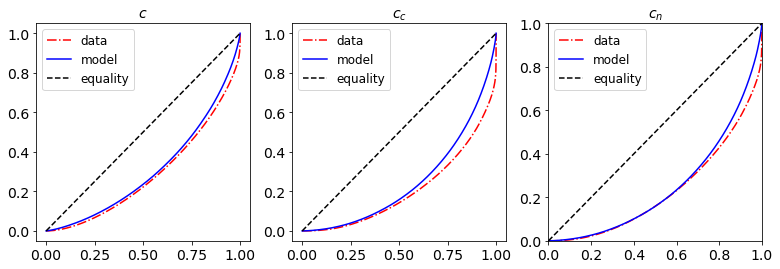

In [56]:
## get lorenz curve of the consumption inequality 

C_model = c_dist[:,-1]
C1_model = c1_dist[:,-1]
C2_model = c2_dist[:,-1]

## multiply by permanent income 
CO_model = np.multiply(c_dist[:,-1],p_income_mat[:,-1])
CO1_model = np.multiply(c1_dist[:,-1],p_income_mat[:,-1])
CO2_model = np.multiply(c2_dist[:,-1],p_income_mat[:,-1])

fc_m_vals, lc_m_vals = qe.lorenz_curve(CO_model)
fc1_m_vals, lc1_m_vals = qe.lorenz_curve(CO1_model)
fc2_m_vals, lc2_m_vals = qe.lorenz_curve(CO2_model)


fig, axs = plt.subplots(1,
                        3,
                        figsize=(13,4))

## total consumption 
axs[0].plot(fc_vals, lc_vals, 'r-.',label='data')
axs[0].plot(fc_m_vals, lc_m_vals, 'b-',label='model')
axs[0].plot(fc_vals, fc_vals, 'k--',label='equality')
axs[0].legend(fontsize=legendsize)
axs[0].set_title(r'$c$',fontsize=fontsize)
#plt.xlim([0,1])
#plt.ylim([0,1])

## conctact consumption 

## total consumption 
axs[1].plot(fc1_vals, lc1_vals, 'r-.',label='data')
axs[1].plot(fc1_m_vals, lc1_m_vals, 'b-',label='model')
axs[1].plot(fc1_vals, fc1_vals, 'k--',label='equality')
axs[1].legend(fontsize=legendsize)
axs[1].set_title(r'$c_c$',fontsize=fontsize)
#plt.xlim([0,1])
#plt.ylim([0,1])


## total consumption 
axs[2].plot(fc2_vals, lc2_vals, 'r-.',label='data')
axs[2].plot(fc2_m_vals, lc1_m_vals, 'b-',label='model')
axs[2].plot(fc2_vals, fc2_vals, 'k--',label='equality')
axs[2].legend(fontsize=legendsize)
axs[2].set_title(r'$c_n$',fontsize=fontsize)
plt.xlim([0,1])
plt.ylim([0,1])

plt.show()
fig.savefig('../graph/model/lorenz_c.jpg')

## Then, solve the model with the pandemic 



In [57]:
ifp.b_y = -0.1
ifp.b_s = -0.2

In [58]:
## Pandemic Markov 

## feed a markov tanchened from ar1
## these parameters are estimated from Covid19 cases per capita of all U.S. counties during the pandemic 

ρ, σ = (0.978,0.18)
constant = 0.13  
mc = qe.markov.approximation.tauchen(ρ, σ, b=constant, m=3, n=7)
z_ss_av = constant/(1-ρ)
z_ss_sd = σ*np.sqrt(1/(1-ρ**2))

## feed ifp with a markov matrix 
ifp.z_val, ifp.P = mc.state_values, mc.P

## some initial guesses 
k = len(ifp.s_grid)
n = len(ifp.P)
σ_init = np.empty((k, n))
for z in range(n):
    σ_init[:, z] = ifp.s_grid
a_init = np.copy(σ_init)

In [59]:
a_star, σ_star = solve_model_time_iter(ifp,a_init, σ_init)

Error at iteration 50 is 0.002146414780226813.
Error at iteration 100 is 0.0007843227956180199.
Error at iteration 150 is 0.00047768428625771797.
Error at iteration 200 is 0.0003346376274815377.
Error at iteration 250 is 0.00024637405251515254.
Error at iteration 300 is 0.0001857151048272332.
Error at iteration 350 is 0.00014212568494076372.
Error at iteration 400 is 0.00011003970810674613.
Error at iteration 450 is 8.602229155685315e-05.
Error at iteration 500 is 6.780360349101233e-05.
Error at iteration 550 is 5.382718559399091e-05.
Error at iteration 600 is 4.299909506899624e-05.
Error at iteration 650 is 3.453623319293886e-05.
Error at iteration 700 is 2.7869818949866065e-05.
Error at iteration 750 is 2.2581586592185232e-05.
Error at iteration 800 is 1.8360465712796703e-05.
Error at iteration 850 is 1.4972647404798423e-05.
Error at iteration 900 is 1.2240620717807182e-05.
Error at iteration 950 is 1.0028323529809313e-05.
Error at iteration 1000 is 8.230516299834179e-06.
Error at it

In [62]:
## interpolate consumption function on continuous z grid 
σ_= policyfunc(ifp,
               a_star,
               σ_star,
               discrete = False)

Text(0, 0.5, 'infection')

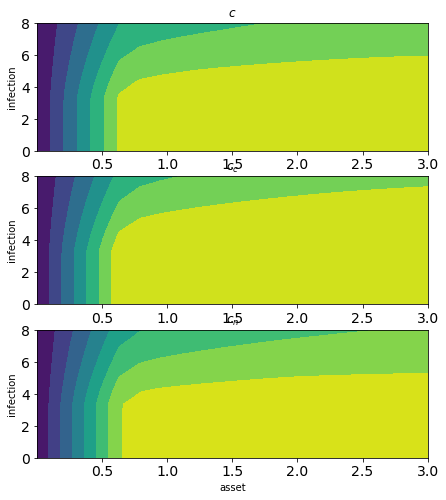

In [63]:
## plot contour for policy function 

a_grid = np.linspace(0.00001,3,20)
z_grid = np.linspace(0,8,20)
aa,zz = np.meshgrid(a_grid,z_grid)

c_stars = σ_(a_grid,z_grid)
c1_stars,c2_stars = allocate(c_stars,S = 1)

fig,ax = plt.subplots(3,1,figsize=(7,8))

cp1 = ax[0].contourf(aa, zz,c_stars)
ax[0].set_title(r'$c$')
ax[0].set_xlabel('asset')
ax[0].set_ylabel('infection')


cp2 = ax[1].contourf(aa, zz,c1_stars)
ax[1].set_title(r'$c_c$')
ax[1].set_xlabel('asset')
ax[1].set_ylabel('infection')


cp3 = ax[2].contourf(aa, zz,c2_stars)
ax[2].set_title(r'$c_n$')
ax[2].set_xlabel('asset')
ax[2].set_ylabel('infection')